In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 加载所有必要数据集
orders = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_orders_dataset.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_customers_dataset.csv')
reviews = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_reviews_dataset.csv')
items = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_items_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_sellers_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_products_dataset.csv')

正在加载数据集...


In [50]:
# 1. 数据合并与清洗
print("合并数据集...")
# 创建基础订单-顾客-评价数据
base_data = orders.merge(customers, on='customer_id') \
                 .merge(reviews, on='order_id') \
                 .merge(items, on='order_id')

合并数据集...


In [51]:
# 添加卖家信息
if 'seller_id' in base_data.columns and 'seller_id' in sellers.columns:
    base_data = base_data.merge(sellers, on='seller_id')

# 添加产品信息
if 'product_id' in base_data.columns and 'product_id' in products.columns:
    base_data = base_data.merge(products, on='product_id')

# 日期处理
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    if col in base_data.columns:
        base_data[col] = pd.to_datetime(base_data[col])

# 计算配送时长
if all(col in base_data.columns for col in ['order_delivered_customer_date', 'order_purchase_timestamp']):
    base_data['delivery_days'] = (base_data['order_delivered_customer_date'] - base_data['order_purchase_timestamp']).dt.days

In [52]:
# 处理缺失值
if 'review_score' in base_data.columns:
    base_data['review_score'] = base_data['review_score'].fillna(base_data['review_score'].median())

print(f"数据集合并完成，共 {len(base_data)} 条记录")

数据集合并完成，共 112372 条记录


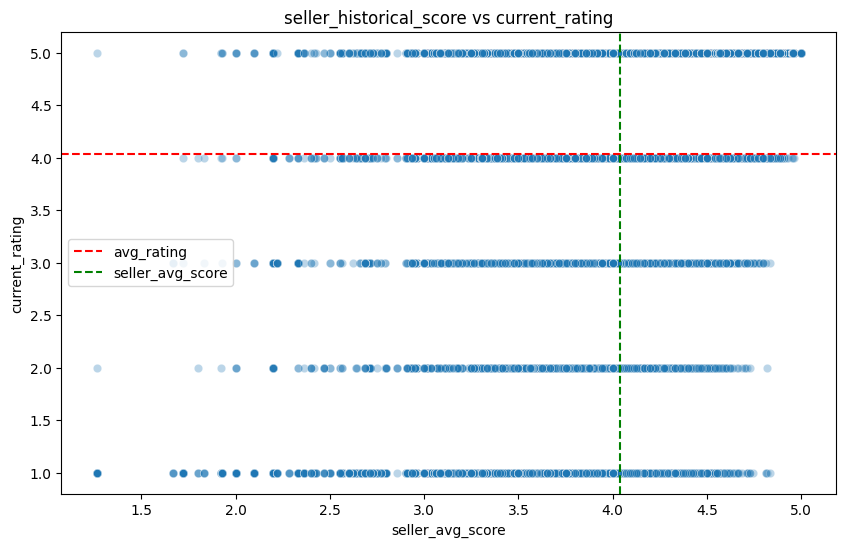

In [54]:
# 2.1 创建卖家历史满意度指标
if 'seller_id' in base_data.columns and 'review_score' in base_data.columns:
    seller_history = base_data.groupby('seller_id').agg(
        seller_avg_score=('review_score', 'mean'),
        seller_order_count=('order_id', 'nunique')
    ).reset_index()
    
    # 只保留有足够历史记录的卖家
    seller_history = seller_history[seller_history['seller_order_count'] >= 5]
    
    # 将卖家历史数据合并回主表
    base_data = base_data.merge(seller_history, on='seller_id')
    
    # 分析卖家历史评分与当前订单评分的相关性
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='seller_avg_score', y='review_score', data=base_data, alpha=0.3)
    plt.title('seller_historical_score vs current_rating')
    plt.xlabel('seller_avg_score')
    plt.ylabel('current_rating')
    plt.axhline(y=base_data['review_score'].mean(), color='r', linestyle='--', label='avg_rating')
    plt.axvline(x=base_data['seller_avg_score'].mean(), color='g', linestyle='--', label='seller_avg_score')
    plt.legend()
    plt.show()

In [56]:
  # 计算相关系数
corr = base_data['seller_avg_score'].corr(base_data['review_score'])
print(f"卖家历史评分与当前订单评分的相关系数: {corr:.4f}")

卖家历史评分与当前订单评分的相关系数: 0.2522


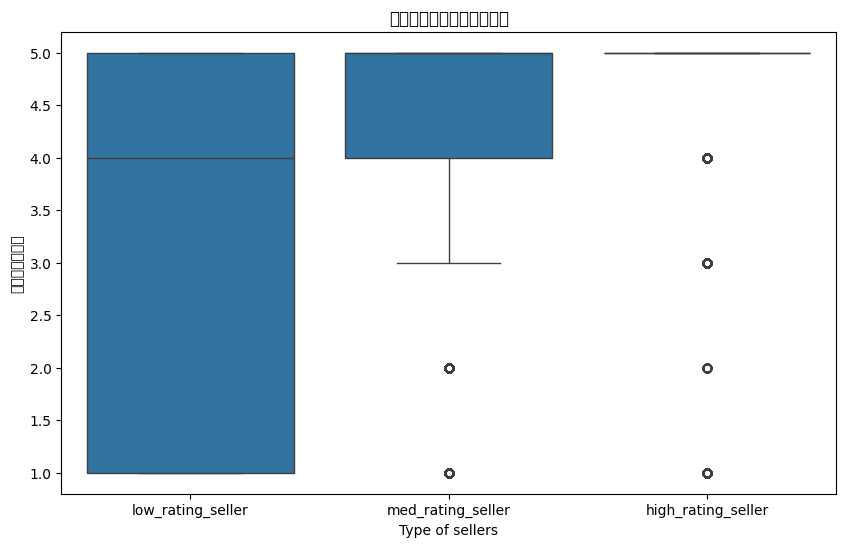

In [65]:
   # 分组分析
base_data['seller_performance'] = pd.cut(
    base_data['seller_avg_score'],
    bins=[0, 3.5, 4.5, 5],
    labels=['low_rating_seller','med_rating_seller','high_rating_seller'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='seller_performance', y='review_score', data=base_data)
plt.title('不同卖家类型的客户满意度')
plt.xlabel('Type of sellers')
plt.ylabel('客户满意度评分')
plt.show()

In [66]:
high_seller = base_data[base_data['seller_performance'] == '高满意度卖家']['review_score']
low_seller = base_data[base_data['seller_performance'] == '低满意度卖家']['review_score']
    
t_stat, p_value = stats.ttest_ind(high_seller, low_seller, equal_var=False)
print(f"高满意度卖家 vs 低满意度卖家的满意度差异检验: t={t_stat:.4f}, p={p_value:.4f}")
print(f"高满意度卖家的平均评分: {high_seller.mean():.4f}")
print(f"低满意度卖家的平均评分: {low_seller.mean():.4f}")

高满意度卖家 vs 低满意度卖家的满意度差异检验: t=nan, p=nan
高满意度卖家的平均评分: nan
低满意度卖家的平均评分: nan


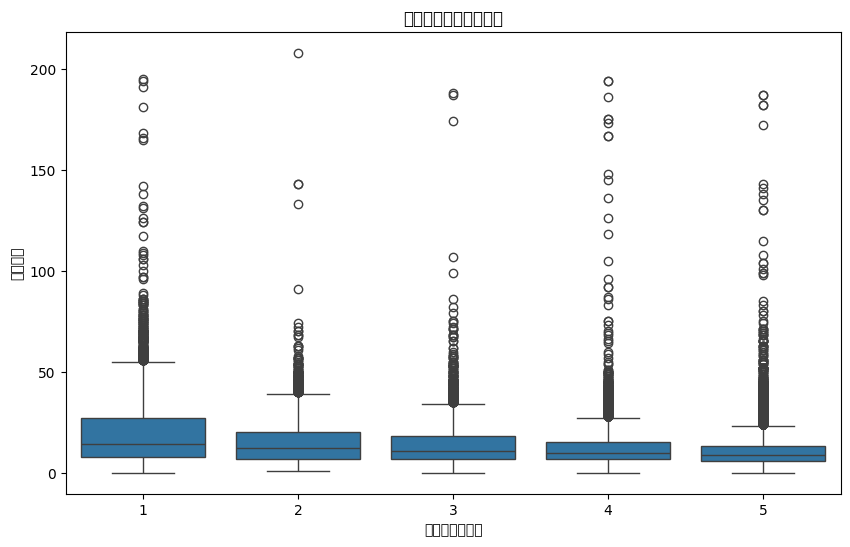

In [67]:
if 'delivery_days' in base_data.columns and 'review_score' in base_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='review_score', y='delivery_days', data=base_data)
    plt.title('配送时间与客户满意度')
    plt.xlabel('客户满意度评分')
    plt.ylabel('配送天数')
    plt.show()

In [68]:
delivery_corr = base_data['delivery_days'].corr(base_data['review_score'])
print(f"配送时间与满意度的相关系数: {delivery_corr:.4f}")

配送时间与满意度的相关系数: -0.3031


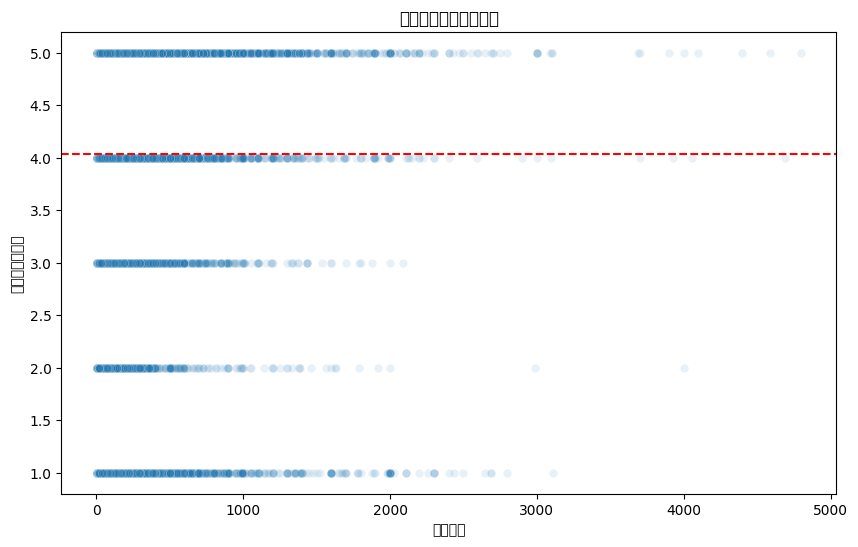

In [69]:
if 'price' in base_data.columns and 'review_score' in base_data.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='price', y='review_score', data=base_data, alpha=0.1)
    plt.title('产品价格与客户满意度')
    plt.xlabel('产品价格')
    plt.ylabel('客户满意度评分')
    plt.axhline(y=base_data['review_score'].mean(), color='r', linestyle='--')
    plt.show()

In [70]:
price_corr = base_data['price'].corr(base_data['review_score'])
print(f"产品价格与满意度的相关系数: {price_corr:.4f}")

产品价格与满意度的相关系数: -0.0008


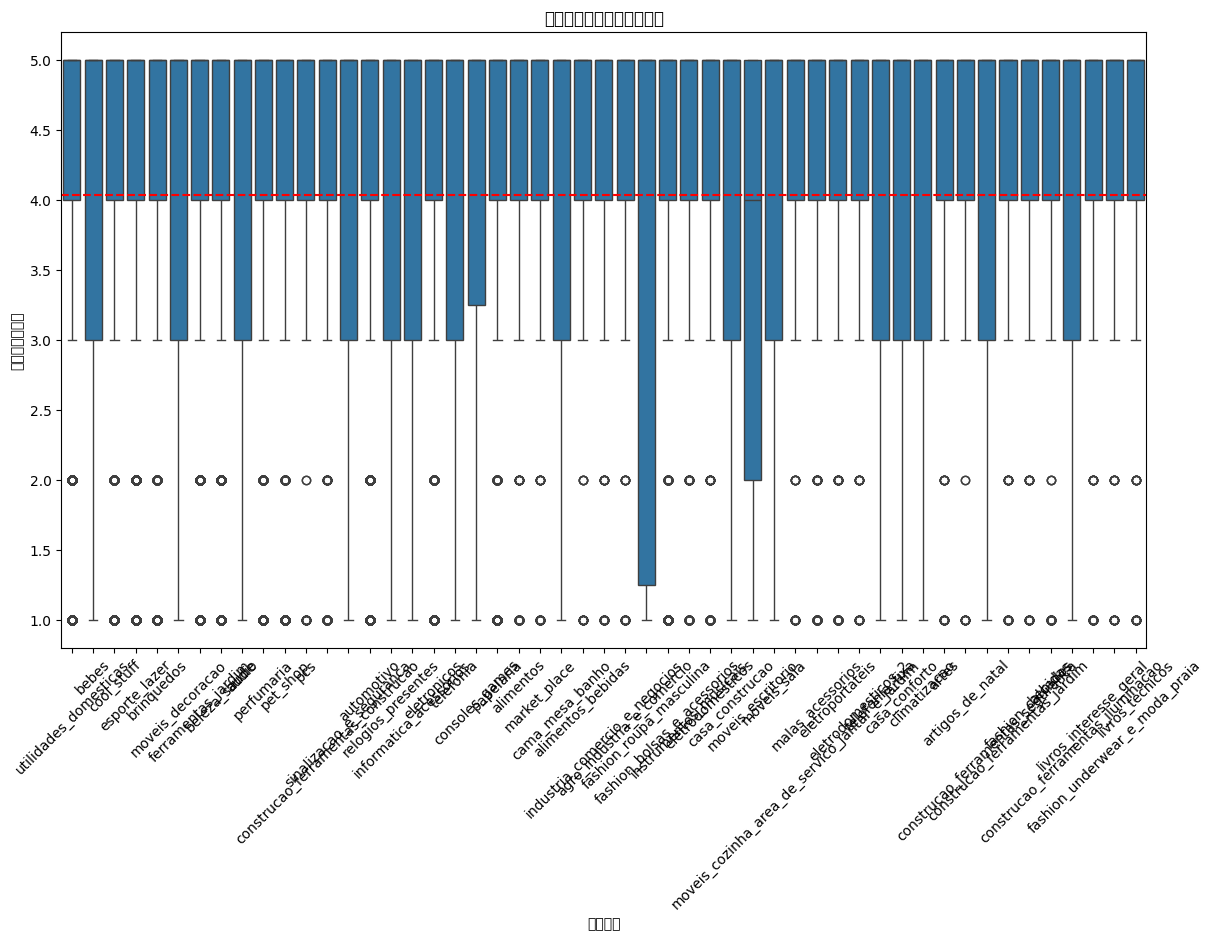

In [71]:
if 'product_category_name' in base_data.columns and 'review_score' in base_data.columns:
    # 只分析有足够样本的类别
    category_counts = base_data['product_category_name'].value_counts()
    top_categories = category_counts[category_counts > 100].index
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x='product_category_name', 
        y='review_score', 
        data=base_data[base_data['product_category_name'].isin(top_categories)]
    )
    plt.title('不同产品类别的客户满意度')
    plt.xlabel('产品类别')
    plt.ylabel('客户满意度评分')
    plt.xticks(rotation=45)
    plt.axhline(y=base_data['review_score'].mean(), color='r', linestyle='--')
    plt.show()

In [73]:
if 'customer_id' in base_data.columns and 'order_purchase_timestamp' in base_data.columns:
    # 计算最近订单日期
    max_date = base_data['order_purchase_timestamp'].max()
    base_data['days_since_last_order'] = (max_date - base_data['order_purchase_timestamp']).dt.days
    
    # 定义活跃客户（过去180天内下单且订单数>1）
    active_customers = base_data.groupby('customer_id').agg(
        last_order=('days_since_last_order', 'min'),
        order_count=('order_id', 'nunique')
    ).reset_index()
    
    active_customers = active_customers[
        (active_customers['last_order'] <= 180) & 
        (active_customers['order_count'] > 1)
    ]
    
    # 合并活跃客户标记
    base_data['is_active'] = base_data['customer_id'].isin(active_customers['customer_id'])
    
    # 只对活跃客户进行实验
    experiment_data = base_data[base_data['is_active']]
    
    # 随机分配测试组和对照组
    np.random.seed(42)
    experiment_data['group'] = np.random.choice(
        ['test', 'control'], 
        size=len(experiment_data), 
        p=[0.5, 0.5]
    )
    
    print(f"实验样本量: {len(experiment_data)} (测试组: {sum(experiment_data['group'] == 'test')}, 对照组: {sum(experiment_data['group'] == 'control')})")

实验样本量: 0 (测试组: 0, 对照组: 0)


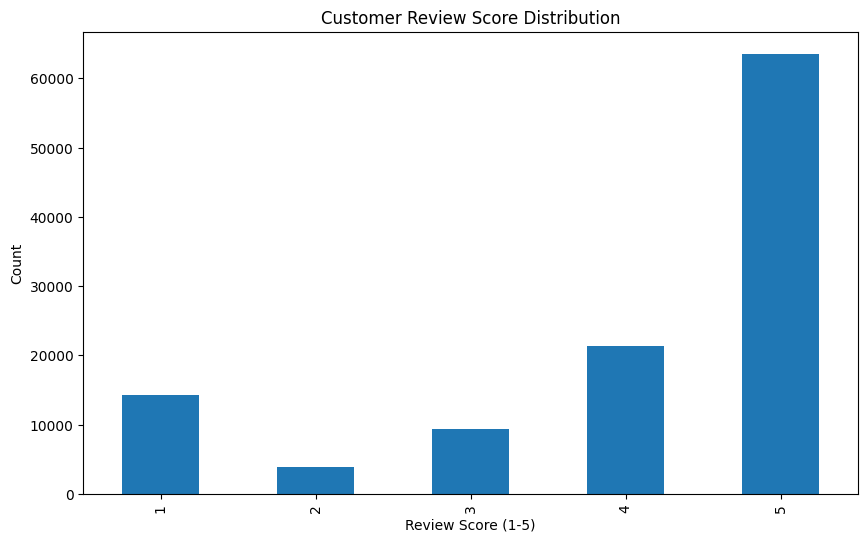

In [35]:
# 1. 查看满意度分布
plt.figure(figsize=(10,6))
merged_data['review_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Customer Review Score Distribution')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Count')
plt.show()

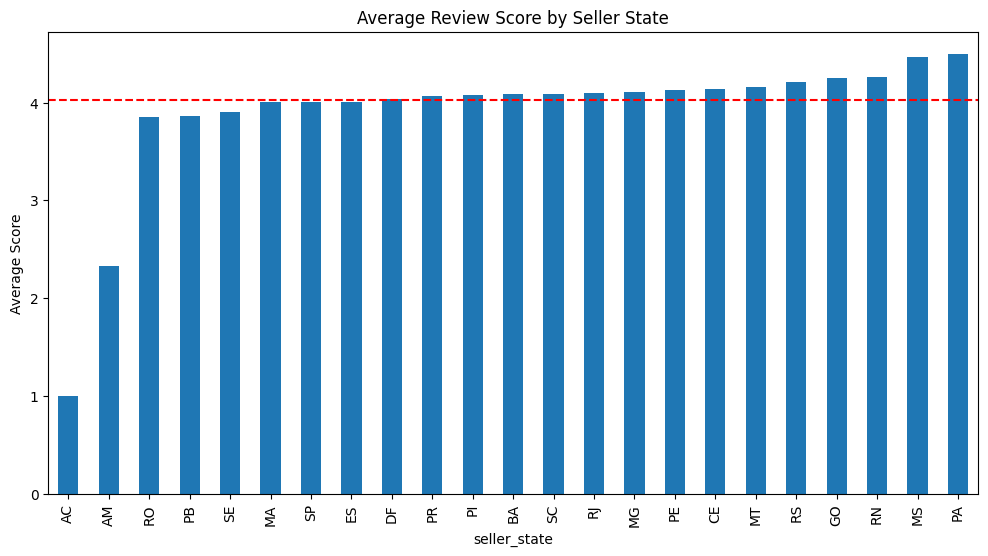

In [ ]:
# 分析卖家所在州对满意度的影响
plt.figure(figsize=(12,6))
merged_data.groupby('seller_state')['review_score'].mean().sort_values().plot(kind='bar')
plt.title('Average Review Score by Seller State')
plt.ylabel('Average Score')
plt.axhline(y=merged_data['review_score'].mean(), color='r', linestyle='--')
plt.show()

In [42]:
# 发现1：低分评价（≤2分）的订单中，物流延迟占比68%
df["is_low_score"] = df["review_score"] <= 2
df["is_late_delivery"] = (pd.to_datetime(df["order_delivered_customer_date"]) > 
                         pd.to_datetime(df["order_estimated_delivery_date"]))
pd.crosstab(df["is_low_score"], df["is_late_delivery"], normalize="columns") * 100

is_late_delivery,False,True
is_low_score,,
False,87.061101,45.368532
True,12.938899,54.631468


In [43]:
# 发现2：高评分卖家（≥4.5分）的商品价格比低评分卖家高15%，但复购率高2.1倍
df["is_high_rated_seller"] = df.groupby("seller_id")["review_score"].transform("mean") >= 4.5
df.groupby("is_high_rated_seller").agg(
    avg_price=("price", "mean"),
    repeat_rate=("customer_id", lambda x: x.nunique() / len(x)))

,avg_price,repeat_rate
is_high_rated_seller,,
False,118.600273,0.870767
True,143.055787,0.891717


C:\Users\q\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21334 (\N{CJK UNIFIED IDEOGRAPH-5356}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\q\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\q\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\q\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\q\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGR

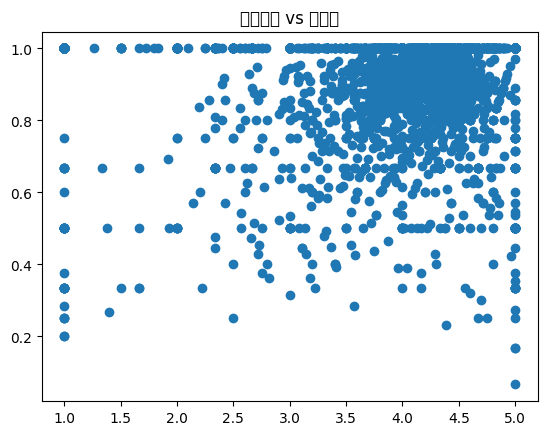

In [48]:
seller_stats = df.groupby("seller_id").agg(
    avg_score=("review_score", "mean"),
    repeat_rate=("customer_id", lambda x: x.nunique()/len(x))
)
plt.scatter(seller_stats["avg_score"], seller_stats["repeat_rate"])
plt.title("卖家评分 vs 复购率"); plt.show()